In [1]:
import pandas as pd

In [2]:
teams_df = pd.read_excel('train.xlsx')
current_df = pd.read_excel('test.xlsx')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
teams_df = teams_df.drop(columns=['Date'])
current_df = current_df.drop(columns=['Date'])

In [5]:
X = teams_df.drop(columns=['Target'])
y = teams_df['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_test = current_df.drop(columns=['Target'])
y_test = current_df['Target']

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [9]:
class GamesData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [10]:
train_data = GamesData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data = GamesData(torch.FloatTensor(X_val), torch.FloatTensor(y_val.to_numpy()))
test_data = GamesData(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

In [11]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

training_loaders = {'train': train_loader, 'val': val_loader}

In [12]:
def binary_acc(y_pred, y_test):
    correct_results_sum = (torch.round(y_pred) == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [13]:
n_epochs = 100
lr = 0.01

In [14]:
models = []

## With LeakyReLu, BatchNorm & 3 Layers

In [15]:
class BinaryFCNN(nn.Module):
    def __init__(self, input_size):
        super(BinaryFCNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.leaky_relu(self.fc1(inputs))
        x = self.bn1(x)
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.bn2(x)
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        
        return x

In [16]:
model = BinaryFCNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [17]:
history = {'train': {'Loss': [], 'Accuracy': []}, 
           'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*n_epochs}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in training_loaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(training_loaders[phase])
        history[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(training_loaders[phase])
        history[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

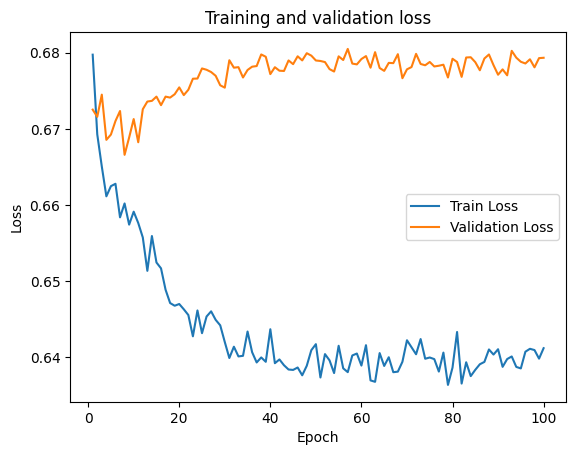

In [19]:
plt.plot(range(1, n_epochs+1), history['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

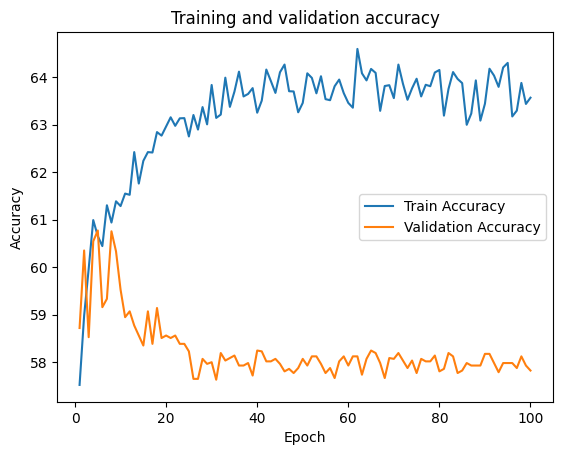

In [20]:
plt.plot(range(1, n_epochs+1), history['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
model.eval()
test_losses, test_accs = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        test_loss = criterion(outputs, labels.unsqueeze(1))
        test_acc = binary_acc(outputs, labels.unsqueeze(1))
        
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())

avg_test_loss = sum(test_losses) / len(test_losses)
avg_test_acc = sum(test_accs) / len(test_accs)
print(f"Average Test Loss: {avg_test_loss}")
print(f"Average Test Accuracy: {avg_test_acc}")

Average Test Loss: 0.5584165118634701
Average Test Accuracy: 71.60416666666667


In [22]:
models.append({'Name': 'Leaky-Batch-3L', 'File': 'TrainedModels/FCNNs/FCNN1.pt', 
               'model': model, 'Accuracy': avg_test_acc, 'Loss': avg_test_loss})

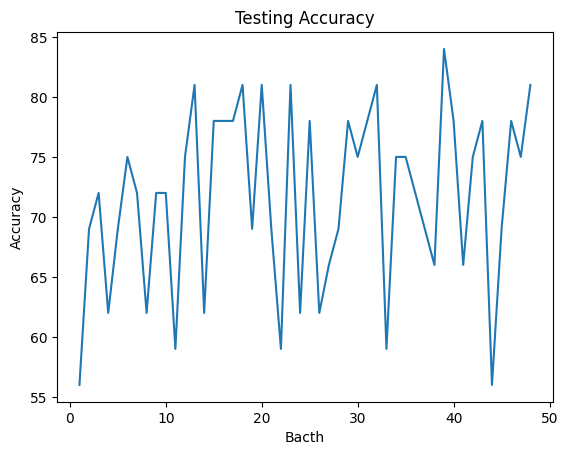

In [23]:
plt.plot(range(1, len(test_accs)+1), test_accs)
plt.title('Testing Accuracy')
plt.xlabel('Bacth')
plt.ylabel('Accuracy')
plt.show()

## With LeakyReLu, BatchNorm & 4 Layers

In [24]:
class BinaryFCNN2(nn.Module):
    def __init__(self, input_size):
        super(BinaryFCNN2, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        x = self.leaky_relu(self.fc1(inputs))
        x = self.bn1(x)
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.bn2(x)
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.bn3(x)
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.bn4(x)
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc5(x))
        
        return x

In [25]:
model2 = BinaryFCNN2(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [26]:
history2 = {'train': {'Loss': [], 'Accuracy': []}, 
           'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*n_epochs}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model2.train()
            
        else:
            model2.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in training_loaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model2(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(training_loaders[phase])
        history2[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(training_loaders[phase])
        history2[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

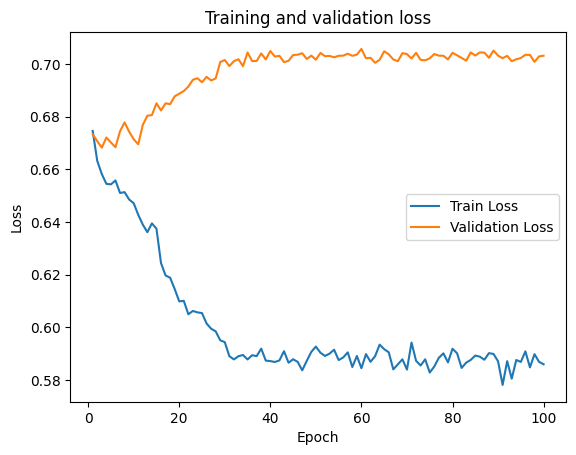

In [27]:
plt.plot(range(1, n_epochs+1), history2['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history2['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

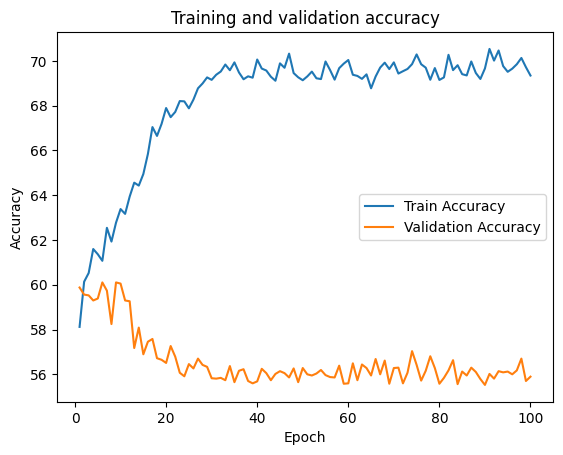

In [28]:
plt.plot(range(1, n_epochs+1), history2['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history2['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
model2.eval()
test_losses2, test_accs2 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model2(inputs)
        
        test_loss = criterion(outputs, labels.unsqueeze(1))
        test_acc = binary_acc(outputs, labels.unsqueeze(1))
        
        test_losses2.append(test_loss.item())
        test_accs2.append(test_acc.item())

avg_test_loss2 = sum(test_losses2) / len(test_losses2)
avg_test_acc2 = sum(test_accs2) / len(test_accs2)
print(f"Average Test Loss: {avg_test_loss2}")
print(f"Average Test Accuracy: {avg_test_acc2}")

Average Test Loss: 0.6435542590916157
Average Test Accuracy: 63.25


In [30]:
models.append({'Name': 'Leaky-Batch-4L', 'File': 'TrainedModels/FCNNs/FCNN2.pt', 
               'model': model2, 'Accuracy': avg_test_acc2, 'Loss': avg_test_loss2})

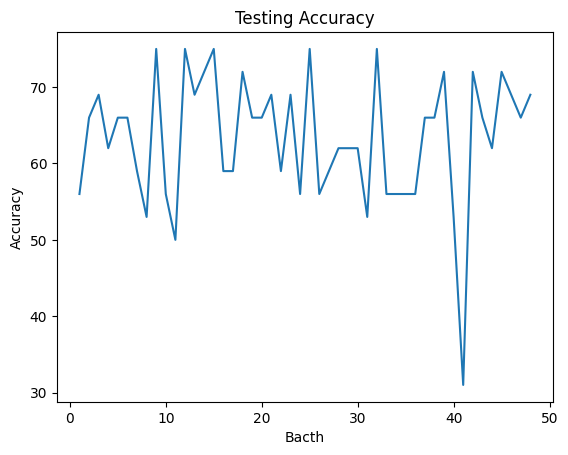

In [31]:
plt.plot(range(1, len(test_accs2)+1), test_accs2)
plt.title('Testing Accuracy')
plt.xlabel('Bacth')
plt.ylabel('Accuracy')
plt.show()

## With LeakyReLu & 3 Layers

In [32]:
class BinaryFCNN3(nn.Module):
    def __init__(self, input_size):
        super(BinaryFCNN3, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, inputs):
        x = self.leaky_relu(self.fc1(inputs))
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        
        return x

In [33]:
model3 = BinaryFCNN3(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model3.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [34]:
history3 = {'train': {'Loss': [], 'Accuracy': []}, 
           'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*n_epochs}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model3.train()
            
        else:
            model3.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in training_loaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model3(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(training_loaders[phase])
        history3[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(training_loaders[phase])
        history3[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

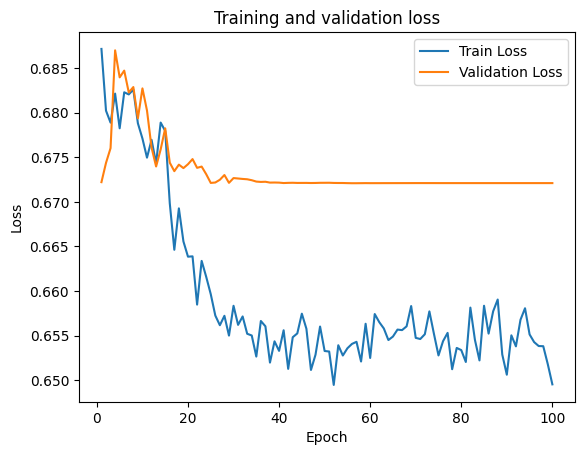

In [35]:
plt.plot(range(1, n_epochs+1), history3['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history3['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

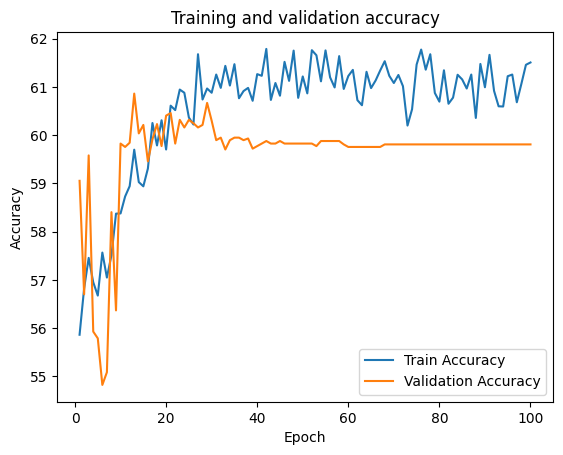

In [36]:
plt.plot(range(1, n_epochs+1), history3['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history3['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
model3.eval()
test_losses3, test_accs3 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model3(inputs)
        
        test_loss = criterion(outputs, labels.unsqueeze(1))
        test_acc = binary_acc(outputs, labels.unsqueeze(1))
        
        test_losses3.append(test_loss.item())
        test_accs3.append(test_acc.item())

avg_test_loss3 = sum(test_losses3) / len(test_losses3)
avg_test_acc3 = sum(test_accs3) / len(test_accs3)
print(f"Average Test Loss: {avg_test_loss3}")
print(f"Average Test Accuracy: {avg_test_acc3}")

Average Test Loss: 0.5981793080766996
Average Test Accuracy: 69.35416666666667


In [38]:
models.append({'Name': 'Leaky-3L', 'File': 'TrainedModels/FCNNs/FCNN3.pt', 
               'model': model3, 'Accuracy': avg_test_acc3, 'Loss': avg_test_loss3})

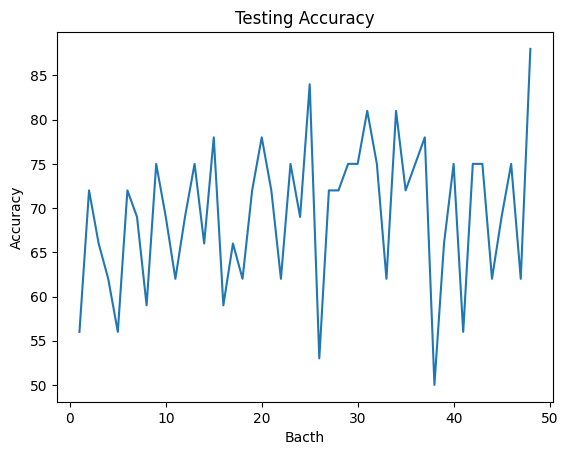

In [39]:
plt.plot(range(1, len(test_accs3)+1), test_accs3)
plt.title('Testing Accuracy')
plt.xlabel('Bacth')
plt.ylabel('Accuracy')
plt.show()

## With LeakyReLu & 4 Layers

In [40]:
class BinaryFCNN4(nn.Module):
    def __init__(self, input_size):
        super(BinaryFCNN4, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, inputs):
        x = self.leaky_relu(self.fc1(inputs))
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc5(x))
        
        return x

In [41]:
model4 = BinaryFCNN4(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model4.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [42]:
history4 = {'train': {'Loss': [], 'Accuracy': []}, 
           'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*n_epochs}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model4.train()
            
        else:
            model4.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in training_loaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model4(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(training_loaders[phase])
        history4[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(training_loaders[phase])
        history4[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

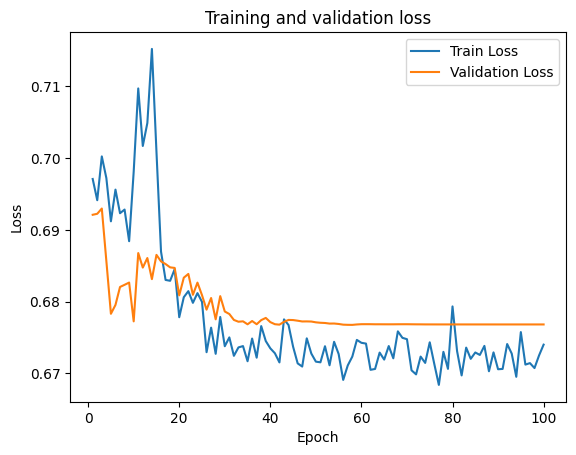

In [43]:
plt.plot(range(1, n_epochs+1), history4['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history4['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

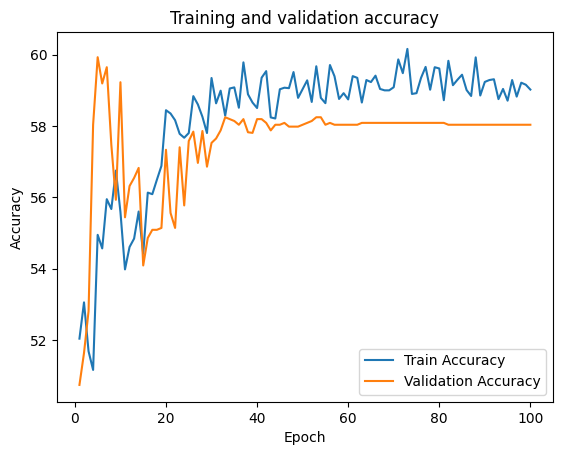

In [44]:
plt.plot(range(1, n_epochs+1), history4['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history4['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
model4.eval()
test_losses4, test_accs4 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model4(inputs)
        
        test_loss = criterion(outputs, labels.unsqueeze(1))
        test_acc = binary_acc(outputs, labels.unsqueeze(1))
        
        test_losses4.append(test_loss.item())
        test_accs4.append(test_acc.item())

avg_test_loss4 = sum(test_losses4) / len(test_losses4)
avg_test_acc4 = sum(test_accs4) / len(test_accs4)
print(f"Average Test Loss: {avg_test_loss4}")
print(f"Average Test Accuracy: {avg_test_acc4}")

Average Test Loss: 0.6198260113596916
Average Test Accuracy: 71.64583333333333


In [46]:
models.append({'Name': 'Leaky-4L', 'File': 'TrainedModels/FCNNs/FCNN4.pt', 
               'model': model4, 'Accuracy': avg_test_acc4, 'Loss': avg_test_loss4})

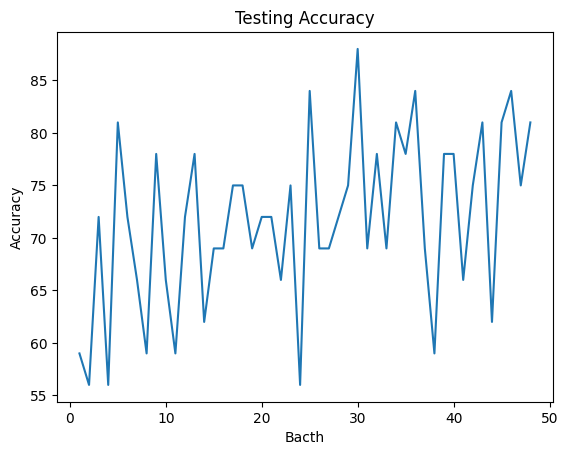

In [47]:
plt.plot(range(1, len(test_accs4)+1), test_accs4)
plt.title('Testing Accuracy')
plt.xlabel('Bacth')
plt.ylabel('Accuracy')
plt.show()

## Models Review

In [48]:
models_df = pd.DataFrame(models)
models_df = models_df.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
models_df[['Name', 'Accuracy', 'Loss']]

,Name,Accuracy,Loss
0,Leaky-4L,71.645833,0.619826
1,Leaky-Batch-3L,71.604167,0.558417
2,Leaky-3L,69.354167,0.598179
3,Leaky-Batch-4L,63.250000,0.643554


In [49]:
models_df.to_excel('TrainedModels/FCNNs/models.xlsx', index=0)

In [50]:
for idx, file in enumerate(models_df['File']):
    file_model = models_df.loc[models_df['File'] == file]['model'][idx]
    torch.save(file_model, file)

In [51]:
import joblib

In [52]:
scaler_file = 'Scalers/FCNN.pkl'
joblib.dump(scaler, scaler_file, compress=True)

['Scalers/FCNN.pkl']